In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[2]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1


In [4]:
data = np.array(df)
m,n = data.shape

y = data[:, 0]
X = data[:,1:]

#normalizing
X = X/255.

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
X_train = X_train.T
X_test = X_test.T


In [5]:
def init_params():
    W1 = np.random.rand(10,784) - 0.5
    b1 = np.random.rand(10,1) - 0.5

    W2 = np.random.rand(10,10) - 0.5
    b2 = np.random.rand(10,1) - 0.5

    return W1,b1,W2,b2

In [6]:
def ReLU(Z):
    return np.maximum(Z,0)

In [7]:
def softmax(Z):
    return np.exp(Z) / sum(np.exp(Z))

In [8]:
def forward_prop(W1,b1,W2,b2,X):

    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)

    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

In [9]:
def one_hot(y):
    one_hot_y = np.zeros((y.size,y.max()+1))
    one_hot_y[np.arange(y.size),y] = 1
    one_hot_y = one_hot_y.T
    return one_hot_y

In [10]:
def deriv_ReLU(Z):
    return Z > 0

In [11]:
def back_prop(Z1, A1, Z2, A2, W2, X, y):
    one_hot_y = one_hot(y)
    dZ2 = A2 - one_hot_y
    dW2 = 1 / m * np.dot(dZ2,A1.T)
    db2 = 1 / m * np.sum(dZ2)

    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1 / m * np.dot(dZ1,X.T)
    db1 = 1 / m * np.sum(dZ1)

    return dW1, db1, dW2, db2

In [12]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1

    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    
    return W1, b1, W2, b2

In [13]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, y):
    print(predictions, y)
    return np.sum(predictions == y) / y.size

In [14]:
def gradient_descent(X, y, alpha, iters):
    W1, b1, W2, b2 = init_params()
    
    for i in range(iters):
        Z1,A1,Z2,A2 = forward_prop(W1,b1,W2,b2,X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, y))
    return W1, b1, W2, b2

In [15]:
W1, b1, W2, b2 = gradient_descent(X_train, y_train, 0.3, 500)

Iteration:  0
[2 2 9 ... 0 2 9] [5 5 6 ... 3 5 6]
0.11479166666666667
Iteration:  10
[7 6 9 ... 3 9 6] [5 5 6 ... 3 5 6]
0.3306547619047619
Iteration:  20
[7 6 6 ... 3 3 6] [5 5 6 ... 3 5 6]
0.4406547619047619
Iteration:  30
[7 5 6 ... 3 3 6] [5 5 6 ... 3 5 6]
0.5252678571428572
Iteration:  40
[7 5 6 ... 3 3 6] [5 5 6 ... 3 5 6]
0.5842857142857143
Iteration:  50
[7 5 6 ... 3 3 6] [5 5 6 ... 3 5 6]
0.6295535714285714
Iteration:  60
[7 5 6 ... 3 3 6] [5 5 6 ... 3 5 6]
0.6610714285714285
Iteration:  70
[7 5 6 ... 3 3 6] [5 5 6 ... 3 5 6]
0.6746428571428571
Iteration:  80
[9 5 6 ... 3 3 6] [5 5 6 ... 3 5 6]
0.6419642857142858
Iteration:  90
[5 5 6 ... 3 3 6] [5 5 6 ... 3 5 6]
0.6851785714285714
Iteration:  100
[5 5 6 ... 3 3 6] [5 5 6 ... 3 5 6]
0.7028869047619047
Iteration:  110
[5 5 6 ... 3 3 6] [5 5 6 ... 3 5 6]
0.7186904761904762
Iteration:  120
[5 5 6 ... 3 3 6] [5 5 6 ... 3 5 6]
0.73375
Iteration:  130
[5 5 6 ... 3 3 6] [5 5 6 ... 3 5 6]
0.7496130952380953
Iteration:  140
[5 5 6 ... 

In [16]:

def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

In [17]:
dev_predictions = make_predictions(X_test, W1, b1, W2, b2)
get_accuracy(dev_predictions, y_test)

[5 5 7 ... 4 5 2] [5 5 9 ... 4 5 2]


0.8875

In [18]:
def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

In [19]:
a = np.random.randint(0,1000,4)

Prediction:  [4]
Label:  4


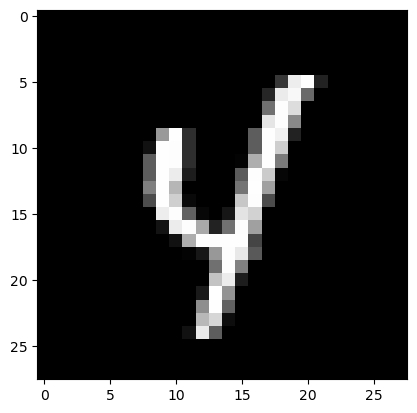

Prediction:  [1]
Label:  1


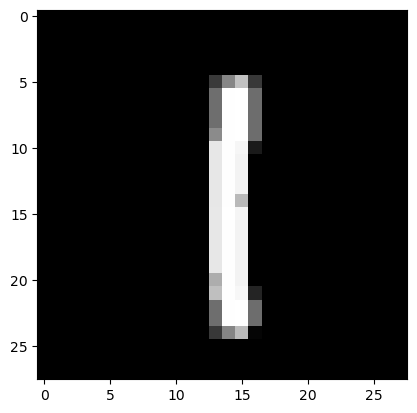

Prediction:  [2]
Label:  2


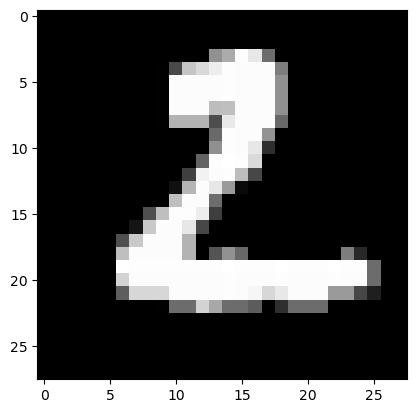

Prediction:  [1]
Label:  1


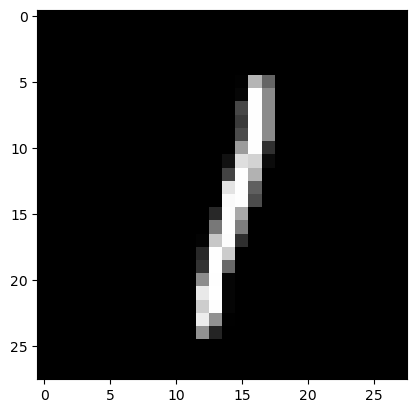

In [20]:
for i in a:
    test_prediction(i, W1, b1, W2, b2)